From here onwards i would like to do the tensorflow model.


In [ ]:
!pip install flask-ngrok
! pip install SpeechRecognition
!apt install libasound2-dev portaudio19-dev
! pip install PyAudio
!pip uninstall ffmpeg 
!pip uninstall ffmpeg-python
! pip install SpeechRecognition
! pip install ffmpeg-python
!pip install librosa

In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
  #DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")#32
        sample_rate=sound_file.samplerate
        #if chroma:
         #   stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=16000, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        #if chroma:
        #    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=16000).T,axis=0)
        #    result=np.hstack((result, chroma))
        #if mel:
         #   mel=np.mean(librosa.feature.melspectrogram(X, sr=16000).T,axis=0)
         #   result=np.hstack((result, mel))
    return result

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['happy','disgust','calm','angry','neutral','surprised','fearful','sad']

In [ ]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size):
    x,y=[],[]
    count_sad=0
    count_happy=0
    for file in glob.glob("/content/drive/MyDrive/ravdess/RAVDESS/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=False, mel=False)
        if emotion=='happy':
          count_happy+=1
        if emotion=='sad':
          count_sad+=1
        if count_sad<=count_happy and emotion=='sad':
          x.append(feature)
          y.append(observed_emotions.index(emotion))
        elif emotion !='sad':
          x.append(feature)
          y.append(observed_emotions.index(emotion))
    count_sad=0
    count_happy=0
    for file in glob.glob("/content/drive/MyDrive/TESS/*.wav"):
        file_name=os.path.basename(file)
        emotion=file_name.split("_")[2][:-4]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=False, mel=False)
        if emotion=='happy':
          count_happy+=1
        if emotion=='sad':
          count_sad+=1
        if count_sad<=count_happy and emotion=='sad':
          x.append(feature)
          y.append(observed_emotions.index(emotion))
        elif emotion !='sad':
          x.append(feature)
          y.append(observed_emotions.index(emotion))   
    return train_test_split(np.array(x), np.array(y), test_size=test_size, random_state=9)

In [ ]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.20)

In [ ]:
x_traincnn=np.expand_dims(x_train,axis=2)
x_testcnn=np.expand_dims(x_test,axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((2234, 40, 1), (559, 40, 1))

In [ ]:

import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import keras
from matplotlib.pyplot import specgram
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense , Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Flatten,Dropout,Activation
from keras.layers import Conv1D,MaxPooling1D,AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix


model=Sequential()
model.add(Conv1D(256,5,padding='same',input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))#0.1/0.2
model.add(Conv1D(128,5,padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128,5,padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128,5,padding='same'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt=keras.optimizers.RMSprop(lr=0.00001,decay=1e-6)


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 40, 256)           1536      
_________________________________________________________________
activation_30 (Activation)   (None, 40, 256)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 40, 128)           163968    
_________________________________________________________________
activation_31 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 5, 128)           

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn,y_train,batch_size=16,epochs=250,validation_data=(x_testcnn,y_test))

Epoch 1/250
140/140 [==============================] - 2s 8ms/step - loss: 3.0475 - accuracy: 0.1824 - val_loss: 1.8663 - val_accuracy: 0.3810
Epoch 2/250
140/140 [==============================] - 1s 5ms/step - loss: 1.9271 - accuracy: 0.2932 - val_loss: 1.6353 - val_accuracy: 0.4597
Epoch 3/250
140/140 [==============================] - 1s 5ms/step - loss: 1.7202 - accuracy: 0.3828 - val_loss: 1.5247 - val_accuracy: 0.4329
Epoch 4/250
140/140 [==============================] - 1s 5ms/step - loss: 1.6309 - accuracy: 0.4099 - val_loss: 1.4250 - val_accuracy: 0.5474
Epoch 5/250
140/140 [==============================] - 1s 5ms/step - loss: 1.5246 - accuracy: 0.4612 - val_loss: 1.3847 - val_accuracy: 0.5116
Epoch 6/250
140/140 [==============================] - 1s 5ms/step - loss: 1.4641 - accuracy: 0.5101 - val_loss: 1.3211 - val_accuracy: 0.5850
Epoch 7/250
140/140 [==============================] - 1s 5ms/step - loss: 1.4135 - accuracy: 0.5340 - val_loss: 1.2702 - val_accuracy: 0.6118

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/my_model')

In [ ]:
#https://heartbeat.fritz.ai/working-with-audio-signals-in-python-6c2bd63b2daf
score = model.evaluate(x_testcnn, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5539900064468384 / Test accuracy: 0.8139534592628479


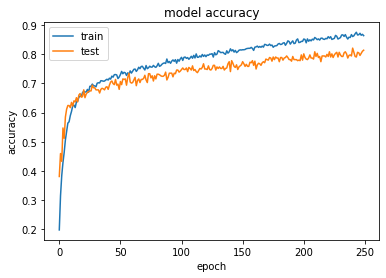

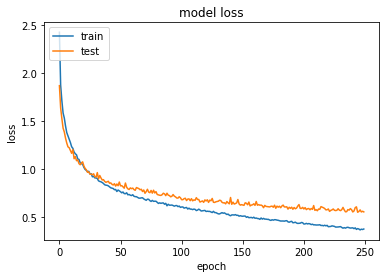

In [ ]:
# summarize history for accuracy
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#model.save('/content/drive/MyDrive/my_model')

In [ ]:
import speech_recognition as sr
import pyaudio
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write
import io
import ffmpeg
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  write('test.wav', 16000, audio)
  return audio, sr

In [ ]:
audio , sr = get_audio()
audio,sr=librosa.load('test.wav',sr=16000)
write('test.wav', 16000, audio)
print(sr,audio)
#commenting second layer drop out gave good predictions

16000 [ 0.          0.          0.         ... -0.00015259 -0.00015259
 -0.00015259]


In [ ]:
feature=extract_feature('/content/test.wav', mfcc=True, chroma=False, mel=False)
feature=np.reshape(feature,(1,-1))
feature=np.expand_dims(feature,axis=2)
a=model.predict(feature)
classes = np.argmax(a, axis = 1)
print(observed_emotions[classes[0]])

neutral
